In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
from plotly import express as px

In this notebook, the data is going to be preprocess, to be ready for the data exploration and model creation

## Functions

In [ ]:
def rename_uname(df):
    for i , columns in enumerate(df.columns.levels):
        column_new = columns.tolist()
        for j, row in enumerate(column_new):
            row = str(row)
            if 'Unnamed' in row:
                column_new[j] = ""
            if "NO" == row:
                column_new = ""
        df = df.rename(columns=dict(zip(columns.tolist(), column_new)),
            level = i)
    return df

def categorize_genre(value):
  ending = value[-7:] 
  if ending == "Mujeres":
    return "Mujeres"
  elif ending == "Hombres":
    return "Hombres"
  else:
    return "Ambos sexos"

def renta_rename(df):
    df = rename_uname(df).reset_index(drop=True)
    years = list(set([col[0] for col in df.columns][1:]))
    df.columns = [''.join(str(col)).strip() for col in df.columns.values]
    df.columns = [col.replace(' ','_').lower() for col in df.columns.values]
    df.columns = [col.replace(',','') for col in df.columns.values]


    df = df.rename(columns={
        "('distrito_/_barrio'_'')": 'distrito_barrio',
        f"({years[1]}_'renta_media_por_persona_')": f'renta_media_por_persona_{years[1]}',
        f"({years[1]}_'renta_media_por_hogar')": f'renta_media_por_hogar_{years[1]}',
        f"({years[0]}_'renta_media_por_persona_')": f'renta_media_por_persona_{years[0]}',
        f"({years[0]}_'renta_media_por_hogar')": f'renta_media_por_hogar_{years[0]}',
    })
    df = df.dropna()
    df['distrito_barrio'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
    df['distrito_barrio'] = df['distrito_barrio'].str.strip()
    return df


def clean_renta(df1):
  list_columns = df1.columns.to_list()
  distritos = df1.distrito_barrio
  list_columns = df1.columns.to_list()
  distritos = df1.distrito_barrio
  list_years = list_columns[1:]
  list_years = [name.split('_')[-1] for name in list_years]
  list_years = list(set(list_years))

  rent_1 = pd.concat([distritos,df1[list_columns[1:3]]],axis=1)
  rent_2 = pd.concat([distritos,df1[list_columns[3:6]]],axis=1)
  rent_1['year'] = list_years[1]
  rent_2['year'] = list_years[0]
  rent_1.columns = rent_1.columns.str.replace(r'_\d+', '', regex=True)
  rent_2.columns = rent_2.columns.str.replace(r'_\d+', '', regex=True)

  rents = pd.concat([rent_1, rent_2])
  return rents

## Paro

Preprocessing the data that came from the ayuntamiento de madrid and save it in csv format.

In [ ]:
paro_madrid_distri = pd.read_excel('../data/madrid/raw/paro/paro_madrid.xlsx',header=[0,2])
paro_madrid_nh = pd.read_excel('../data/madrid/raw/paro/paro_madrid.xlsx',header=[1,2])

districts = pd.read_csv('../data/madrid/cleaned/total_by_district.csv')['district'].tolist()

paro_madrid_distri.head()

In [ ]:
paro_madrid_distri = rename_uname(paro_madrid_distri).reset_index(drop=True)
paro_madrid_distri.columns = [' '.join(col).strip() for col in paro_madrid_distri.columns.values]
paro_madrid_distri.columns = [col.replace(' ','_').lower() for col in paro_madrid_distri.columns.values]
paro_madrid_distri = paro_madrid_distri.drop(paro_madrid_distri.columns[0], axis=1)

paro_madrid_distri.head()

In [ ]:
paro_madrid_nh = rename_uname(paro_madrid_nh).reset_index(drop=True)
paro_madrid_nh.columns = [' '.join(col).strip() for col in paro_madrid_nh.columns.values]
paro_madrid_nh.columns = [col.replace(' ','_').lower() for col in paro_madrid_nh.columns.values]
paro_madrid_nh = paro_madrid_nh.drop(paro_madrid_nh.columns[0], axis=1)

paro_madrid_nh.head()

In [ ]:
paro_madrid_distri = paro_madrid_distri.drop(columns=['ciudad_de_madrid_ambos_sexos'])
paro_madrid_nh = paro_madrid_nh.drop(columns=['ciudad_de_madrid_ambos_sexos'])

In [ ]:
paro_madrid_nh.columns

In [ ]:
import re
pattern = re.compile("\d{2}_")
columns_to_drop = [col for col in paro_madrid_nh.columns if pattern.match(col)]
paro_madrid_nh = paro_madrid_nh.drop(columns=columns_to_drop)
columns_to_drop = [col for col in paro_madrid_nh.columns if 'no_consta' in col]
paro_madrid_nh = paro_madrid_nh.drop(columns=columns_to_drop)
paro_madrid_nh.columns

In [ ]:
import re
pattern = re.compile(".+\d$")
columns_to_drop = [col for col in paro_madrid_distri.columns if pattern.match(col)]
paro_madrid_distri = paro_madrid_distri.drop(columns=columns_to_drop)


In [ ]:
paro_madrid_distri.columns = ['_'.join(col.split('_')[1:]) for col in paro_madrid_distri.columns]
paro_madrid_nh.columns = ['_'.join(col.split('_')[1:]) for col in paro_madrid_nh.columns]

In [ ]:
paro_madrid_distri.head(1)

In [ ]:
paro_madrid_nh.head(1)

In [ ]:
total_paro = pd.DataFrame(paro_madrid_distri.sum())
total_paro['district'] = total_paro.index
total_paro.reset_index(drop=True,inplace=True)
total_paro.rename(columns={0:'total'}, inplace=True)
total_paro = total_paro.reindex(columns=['district','total'])
total_paro['total'] = total_paro['total'].astype(int)
total_paro['district'] = total_paro.district.str.title()
total_paro['genre'] = total_paro['district'].apply(categorize_genre)

genre_map = {"_Mujeres": "", "_Hombres": "", "_Ambos_Sexos": ""}
total_paro['district'] = total_paro['district'].replace(genre_map, regex=True)
total_paro['district'] = total_paro['district'].str.replace('_',' ')
total_paro['district'] = total_paro['district'].str.replace('Vallecas ','')

total_paro = total_paro[~total_paro['district'].isin(['No Consta','Ciudad De Madrid'])]
total_paro.to_csv('../data/madrid/cleaned/paro_by_district.csv')

In [ ]:
total_paro = pd.DataFrame(paro_madrid_nh.sum())
total_paro['district'] = total_paro.index
total_paro.reset_index(drop=True,inplace=True)
total_paro.rename(columns={0:'total'}, inplace=True)
total_paro = total_paro.reindex(columns=['district','total'])
total_paro['total'] = total_paro['total'].astype(int)
total_paro['district'] = total_paro.district.str.title()
total_paro['genre'] = total_paro['district'].apply(categorize_genre)

genre_map = {"_Mujeres": "", "_Hombres": "", "_Ambos_Sexos": ""}
total_paro['district'] = total_paro['district'].replace(genre_map, regex=True)
total_paro['district'] = total_paro['district'].str.replace('_',' ')
total_paro['district'] = total_paro['district'].str.replace('Vallecas ','')

total_paro = total_paro[~total_paro['district'].isin(['No Consta','Ciudad De Madrid'])]
total_paro.to_csv('../data/madrid/cleaned/paro_by_neighbourhood.csv')

## Vivienda

### Datos inmobiliarios

In [ ]:
df_fotocasa = pd.read_csv('../data/madrid/cleaned/fotocasa/fotocasa_2023_located_districts.csv')
df_fotocasa.shape

In [ ]:

df_fotocasa['date_scraped'] = pd.to_datetime('2024-04-09')

df_fotocasa.head()



In [ ]:
fig = plt.figure(figsize=(10,5))

sns.histplot(data=df_fotocasa, x='Price', bins=100, kde=True)
plt.show()

In [ ]:
from scipy.stats import skew

skewness = skew(df_fotocasa['Price'])
print("Skewness:", skewness)

In [ ]:
df_fotocasa['Price'].mean()

In [ ]:
df_fotocasa.isna().sum()

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.title('Price distribution of houses in Madrid more than 500000€')
sns.histplot(data=df_fotocasa[df_fotocasa['Price'] > 500000], x='Price', bins=20, kde=True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Price distribution of houses in Madrid less than 500000€')

sns.histplot(data=df_fotocasa[df_fotocasa['Price'] < 500000], x='Price', bins=100, kde=True)
plt.show()

Outliers

In [ ]:
sns.boxplot(data=df_fotocasa, x='Price')
plt.show()

In [ ]:
Q1 = df_fotocasa['Price'].quantile(0.25)
Q3 = df_fotocasa['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filterd = df_fotocasa[(df_fotocasa['Price'] >= lower_bound) & (df_fotocasa['Price'] <= upper_bound)]

In [ ]:
sns.histplot(data=df_filterd, x='Price', bins=20, kde=True)

### Vivienda m2

In [ ]:
df_housing = pd.read_excel('../data/madrid/raw/vivienda_segunda_mano.xlsx')
df_housing = df_housing.replace('-',0)
df_housing.rename(columns={'Unnamed: 0':'district', 'Unnamed: 1':'barrio'}, inplace=True)
df_housing['district'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
df_housing['barrio'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')

In [ ]:
df_housing_yearly = pd.melt(df_housing, id_vars=['barrio', 'district'], var_name='year', value_name='price')
df_housing_yearly['price'] = df_housing_yearly['price'].astype(float)
df_housing_yearly['year'] = df_housing_yearly['year'].astype(int)
df_housing_yearly.to_csv('../data/madrid/cleaned/sq2_madrid_yearly.csv')
df_housing_yearly.head()

In [ ]:
price_district_m2 = df_housing_yearly.groupby(['district','year']).agg({'price':'mean'}).reset_index()
price_neighbourhood_m2 = df_housing_yearly.groupby(['barrio','year']).agg({'price':'sum'}).reset_index()
price_district_m2

In [ ]:
month_map = {'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
             'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12}

In [ ]:

df_housing_month = pd.read_excel('../data/madrid/raw/vivienda_segunda_mano_mes.xlsx')
df_housing_month = df_housing_month.replace('-',0)
df_housing_month.rename(columns={'Unnamed: 0':'año', 'Unnamed: 1':'district'}, inplace=True)
df_housing_month['district'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
df_housing_month['district'] = df_housing_month['district'].str.strip()

df_housing_month = pd.melt(df_housing_month, id_vars=['año', 'district'], var_name='month', value_name='price')
df_housing_month['price'] = df_housing_month['price'].astype(float)
df_housing_month['month_n'] = df_housing_month['month'].map(month_map).astype(int)
df_housing_month

In [ ]:
df_housing_month['month_w_price'] = df_housing_month[df_housing_month['price'] > 0.0].groupby(['district','año'])['price'].transform('count')
df_housing_month['month_w_price'] = df_housing_month['month_w_price'].fillna(0)
df_housing_month = df_housing_month[df_housing_month['month_w_price'] >= 9]
df_housing_month = df_housing_month.groupby(['district','año']).agg({'price':'mean'}).reset_index()

In [ ]:
df_housing_month[df_housing_month['año'] == 2006]
df_housing_month.año.unique()

In [ ]:
df_housing_month = df_housing_month[~df_housing_month.año.isin([2007, 2008, 2009, 2023])]
df_housing_month.año.unique()

In [ ]:
df_housing_month.to_csv('../data/madrid/cleaned/sq2_madrid_monthly.csv')

In [ ]:
df_housing_concat = pd.concat([df_housing_month, price_district_m2])
df_housing_concat = df_housing_concat.fillna('-')
df_housing_concat['date'] = df_housing_concat['año'].astype(str) + df_housing_concat['year'].astype(str)
df_housing_concat['date'] = df_housing_concat['date'].str.replace('-','').astype(float)
df_housing_concat['date'] = df_housing_concat['date'].astype(int)
df_housing_concat = df_housing_concat.drop(columns=['año','year'])

In [ ]:
df_housing_concat = df_housing_concat.rename(columns={'date':'m2_date', 'price':'price_m2'})

In [ ]:
df_housing_concat.to_csv('../data/madrid/cleaned/sq2_madrid_yearly.csv')

In [ ]:
df_housing_concat

In [ ]:
px.line(df_housing_concat, x='m2_date', y='price_m2', color='district', title='Price per m2 in Madrid by district')

## Renta

In [ ]:
renta_15_16 = pd.read_excel('../data/madrid/raw/renta/renta_15_16.xlsx',skiprows=[0,1,2,3,4], header=[0,1])  
renta_16_17 = pd.read_excel('../data/madrid/raw/renta/renta17_16.xlsx', skiprows=[0,1,2,3,4], header=[0,1])    
renta_17_18 = pd.read_excel('../data/madrid/raw/renta/renta17_18.xlsx', skiprows=[0,1,2,3,4], header=[0,1])    
renta_18_20 = pd.read_excel('../data/madrid/raw/renta/renta19_20.xlsm', skiprows=[0,1,2,3,4], header=[0,1])   

In [ ]:
renta_15_16 = renta_rename(renta_15_16)
renta_16_17 = renta_rename(renta_16_17)
renta_17_18 =  renta_rename(renta_17_18)
renta_19_20 = renta_rename(renta_18_20)

In [ ]:
renta_15_16 = clean_renta(renta_15_16)
renta_16_17 = clean_renta(renta_16_17)
renta_17_18 =  clean_renta(renta_17_18)
renta_19_20 = clean_renta(renta_19_20)

## Points

In [ ]:
points_raw = pd.read_csv('../data/points/amenity.csv')
points_raw.shape

## Dataset Creation

In [23]:
#need to find which categories we wanna locate 
df_amenity = pd.read_csv('../data/points/amenity.csv')
df_amenity.category.unique()

array(['fuel', nan, 'cinema', 'parking_entrance', 'restaurant', 'pub',
       'theatre', 'police', 'parking', 'place_of_worship', 'fast_food',
       'pharmacy', 'bar', 'retail', 'taxi', 'bicycle_parking', 'cafe',
       'bank', 'bench', 'university', 'clinic', 'drinking_water',
       'post_box', 'post_office', 'recycling', 'veterinary', 'atm',
       'social_facility', 'dentist', 'kindergarten', 'nightclub',
       'bicycle_rental', 'library', 'waste_disposal', 'ice_cream',
       'internet_cafe', 'fountain', 'school', 'music_school',
       'language_school', 'dancing_school', 'vending_machine',
       'marketplace', 'bus_station', 'toilets', 'telephone',
       'arts_centre', 'college', 'training', 'hospital', 'doctors',
       'car_rental', 'casino', 'water_point', 'waste_basket',
       'social_centre', 'courthouse', 'car_wash', 'biergarten',
       'community_centre', 'driving_school', 'vacuum_cleaner', 'prison',
       'brothel', 'satellite_dish', 'grave_yard', 'food_court',
  

In [103]:
df_housing = pd.read_csv('../data/madrid/cleaned/fotocasa/fotocasa_2023_located_districts.csv')
df_housing.shape

(14130, 19)

In [104]:
df_housing.rename(columns={'district_geolocated':'distrito_barrio'}, inplace=True)

In [105]:
df_housing.columns = df_housing.columns.str.lower()
df_housing['zipcode'] = df_housing['zipcode'].fillna(0)
df_housing['zipcode'] = df_housing['zipcode'].astype(int)
df_housing['house_id'] = df_housing.index

In [106]:
df_airbnb = pd.read_csv('../data/points/points_count/housing_airbnb.csv')
df_college = pd.read_csv('../data/points/points_count/housing_college.csv')
df_dentist = pd.read_csv('../data/points/points_count/housing_dentist.csv')
df_fast_food = pd.read_csv('../data/points/points_count/housing_fast_food.csv')
df_jewelry = pd.read_csv('../data/points/points_count/housing_jewelry.csv')
df_university = pd.read_csv('../data/points/points_count/housing_university.csv')
df_restaurant = pd.read_csv('../data/points/points_count/housing_restaurant.csv')
df_hospital = pd.read_csv('../data/points/points_count/housing_hospital.csv')
df_pharmacy = pd.read_csv('../data/points/points_count/housing_pharmacies.csv')
df_supermarket = pd.read_csv('../data/points/points_count/housing_supermarket.csv')
df_airbnb.shape, df_college.shape, df_dentist.shape, df_fast_food.shape, df_jewelry.shape, df_university.shape, df_restaurant.shape, df_hospital.shape

((3237335, 2),
 (6265, 2),
 (28298, 2),
 (105914, 2),
 (19743, 2),
 (1312, 2),
 (682458, 2),
 (955, 2))

In [107]:
df_airbn = df_airbnb.groupby('house_id').agg(count=(df_airbnb.columns[1],'count')).reset_index()
df_college = df_college.groupby('house_id').agg(count=(df_college.columns[1],'count')).reset_index()
df_dentist = df_dentist.groupby('house_id').agg(count=(df_dentist.columns[1],'count')).reset_index()
df_fast_food = df_fast_food.groupby('house_id').agg(count=(df_fast_food.columns[1],'count')).reset_index()
df_jewelry = df_jewelry.groupby('house_id').agg(count=(df_jewelry.columns[1],'count')).reset_index()
df_university = df_university.groupby('house_id').agg(count=(df_university.columns[1],'count')).reset_index()
df_restaurant = df_restaurant.groupby('house_id').agg(count=(df_restaurant.columns[1],'count')).reset_index()
df_hospital = df_hospital.groupby('house_id').agg(count=(df_hospital.columns[1],'count')).reset_index()
df_pharmacy = df_pharmacy.groupby('house_id').agg(count=(df_pharmacy.columns[1],'count')).reset_index()
df_supermarket = df_supermarket.groupby('house_id').agg(count=(df_supermarket.columns[1],'count')).reset_index()

In [108]:
df_housing_left = df_housing.merge(df_airbn, on='house_id', how='left', suffixes=('', '_airbnb'))
df_housing_left = df_housing_left.merge(df_college, on='house_id', how='left', suffixes=('', '_college_500'))
df_housing_left = df_housing_left.merge(df_dentist, on='house_id', how='left', suffixes=('', '_dentist_500'))
df_housing_left = df_housing_left.merge(df_fast_food, on='house_id', how='left', suffixes=('', '_fast_food_500'))
df_housing_left = df_housing_left.merge(df_jewelry, on='house_id', how='left', suffixes=('', '_jewelry_500'))
df_housing_left = df_housing_left.merge(df_university, on='house_id', how='left', suffixes=('', '_university_500'))
df_housing_left = df_housing_left.merge(df_restaurant, on='house_id', how='left', suffixes=('', '_restaurant_500'))
df_housing_left = df_housing_left.merge(df_hospital, on='house_id', how='left', suffixes=('', '_hospital_500'))
df_housing_left = df_housing_left.merge(df_pharmacy, on='house_id', how='left', suffixes=('', '_pharmacy_500'))
df_housing_left = df_housing_left.merge(df_pharmacy, on='house_id', how='left', suffixes=('', '_supermarket_500'))


In [109]:
df_housing_left = df_housing_left.rename(columns={'count':'count_airbnb_500'})

In [110]:
df_housing_left[df_housing_left.columns[df_housing_left.columns.str.contains('count')]].fillna(0, inplace=True)

/tmp/ipykernel_7915/2548365896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_housing_left[df_housing_left.columns[df_housing_left.columns.str.contains('count')]].fillna(0, inplace=True)


In [111]:
df_housing_left = df_housing_left[~df_housing_left['neighbourhood'].isna()]
df_housing_left = df_housing_left.fillna(0)
df_housing_left.isna().sum()

address                  0
zipcode                  0
longitude                0
latitude                 0
price                    0
date                     0
rooms                    0
bathrooms                0
surface                  0
floor                    0
elevator                 0
air_conditioner          0
heater                   0
parking                  0
balcony                  0
terrace                  0
swimming_pool            0
neighbourhood            0
distrito_barrio          0
house_id                 0
count_airbnb_500         0
count_college_500        0
count_dentist_500        0
count_fast_food_500      0
count_jewelry_500        0
count_university_500     0
count_restaurant_500     0
count_hospital_500       0
count_pharmacy_500       0
count_supermarket_500    0
dtype: int64

In [112]:
df_housing_left.columns

Index(['address', 'zipcode', 'longitude', 'latitude', 'price', 'date', 'rooms',
       'bathrooms', 'surface', 'floor', 'elevator', 'air_conditioner',
       'heater', 'parking', 'balcony', 'terrace', 'swimming_pool',
       'neighbourhood', 'distrito_barrio', 'house_id', 'count_airbnb_500',
       'count_college_500', 'count_dentist_500', 'count_fast_food_500',
       'count_jewelry_500', 'count_university_500', 'count_restaurant_500',
       'count_hospital_500', 'count_pharmacy_500', 'count_supermarket_500'],
      dtype='object')

In [113]:
df_housing_left.shape

(14124, 30)

In [114]:
df_housing_left = df_housing_left.rename(columns={'distrito_barrio':'district'})

In [115]:
df_merged = df_housing_left

In [116]:
df_merged.columns

Index(['address', 'zipcode', 'longitude', 'latitude', 'price', 'date', 'rooms',
       'bathrooms', 'surface', 'floor', 'elevator', 'air_conditioner',
       'heater', 'parking', 'balcony', 'terrace', 'swimming_pool',
       'neighbourhood', 'district', 'house_id', 'count_airbnb_500',
       'count_college_500', 'count_dentist_500', 'count_fast_food_500',
       'count_jewelry_500', 'count_university_500', 'count_restaurant_500',
       'count_hospital_500', 'count_pharmacy_500', 'count_supermarket_500'],
      dtype='object')

In [117]:
df_merged = df_merged[df_merged['price'] != 0]
df_merged = df_merged[df_merged['surface'] >= 4]

In [118]:
df_merged['rooms/m2'] = df_merged['rooms'] / df_merged['surface']
df_merged['bathrooms/m2'] = df_merged['bathrooms'] / df_merged['surface']

In [119]:
df_merged.to_csv('../data/madrid/cleaned/merged_data.csv')

<Axes: xlabel='price', ylabel='Count'>

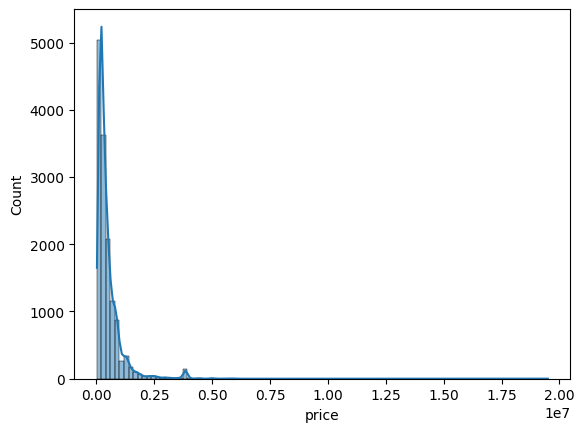

In [120]:
sns.histplot(data=df_merged, x='price', bins=100, kde=True)

In [121]:
Q1 = df_merged['price'].quantile(0.25)
Q3 = df_merged['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filterd = df_merged[(df_merged['price'] >= lower_bound) & (df_merged['price'] <= upper_bound)]

/tmp/ipykernel_7915/204859913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd['price_log'] = np.log(df_filterd['price'])


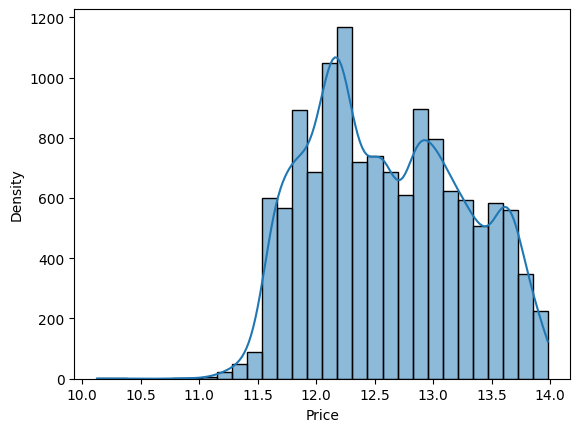

In [122]:
df_filterd['price_log'] = np.log(df_filterd['price'])
sns.histplot(df_filterd['price_log'], kde=True, bins=30)
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

/tmp/ipykernel_7915/1217823439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd['surface_log'] = np.log(df_filterd['surface'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


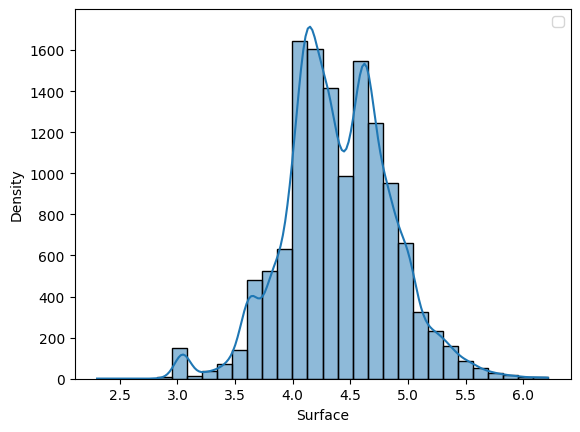

In [123]:
df_filterd['surface_log'] = np.log(df_filterd['surface'])
sns.histplot(df_filterd['surface_log'], kde=True, bins=30)

plt.xlabel('Surface')
plt.ylabel('Density')
plt.legend()
plt.show()

In [124]:
df_filterd.columns

Index(['address', 'zipcode', 'longitude', 'latitude', 'price', 'date', 'rooms',
       'bathrooms', 'surface', 'floor', 'elevator', 'air_conditioner',
       'heater', 'parking', 'balcony', 'terrace', 'swimming_pool',
       'neighbourhood', 'district', 'house_id', 'count_airbnb_500',
       'count_college_500', 'count_dentist_500', 'count_fast_food_500',
       'count_jewelry_500', 'count_university_500', 'count_restaurant_500',
       'count_hospital_500', 'count_pharmacy_500', 'count_supermarket_500',
       'rooms/m2', 'bathrooms/m2', 'price_log', 'surface_log'],
      dtype='object')

In [127]:
df_filterd[['district']]

,district
0,Retiro
1,San Blas - Canillejas
2,San Blas - Canillejas
3,Centro
5,Chamberí
...,...
14125,Centro
14126,Carabanchel
14127,Latina
14128,Latina


In [130]:
import json
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df_filterd['district_encoded'] = encoder.fit_transform(df_filterd['district'])

df_filterd['neighbourhood_encoded'] = encoder.fit_transform(df_filterd['neighbourhood'])

encoder.fit(df_filterd['district'])
district_mapping = {label: idx for idx, label in enumerate(encoder.classes_)}
with open('district_mapping.json', 'w') as f:
    json.dump(district_mapping, f)

encoder.fit(df_filterd['neighbourhood'])
neighbourhood_mapping = {label: idx for idx, label in enumerate(encoder.classes_)}

with open('neighbourhood_mapping.json', 'w') as f:
    json.dump(neighbourhood_mapping, f)

/tmp/ipykernel_7915/3060209069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd['district_encoded'] = encoder.fit_transform(df_filterd['district'])
/tmp/ipykernel_7915/3060209069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd['neighbourhood_encoded'] = encoder.fit_transform(df_filterd['neighbourhood'])


In [89]:
df_filterd = df_filterd.drop(columns=['address','price','surface','date','neighbourhood','district','house_id'])

In [90]:
df_filterd = df_filterd.dropna()

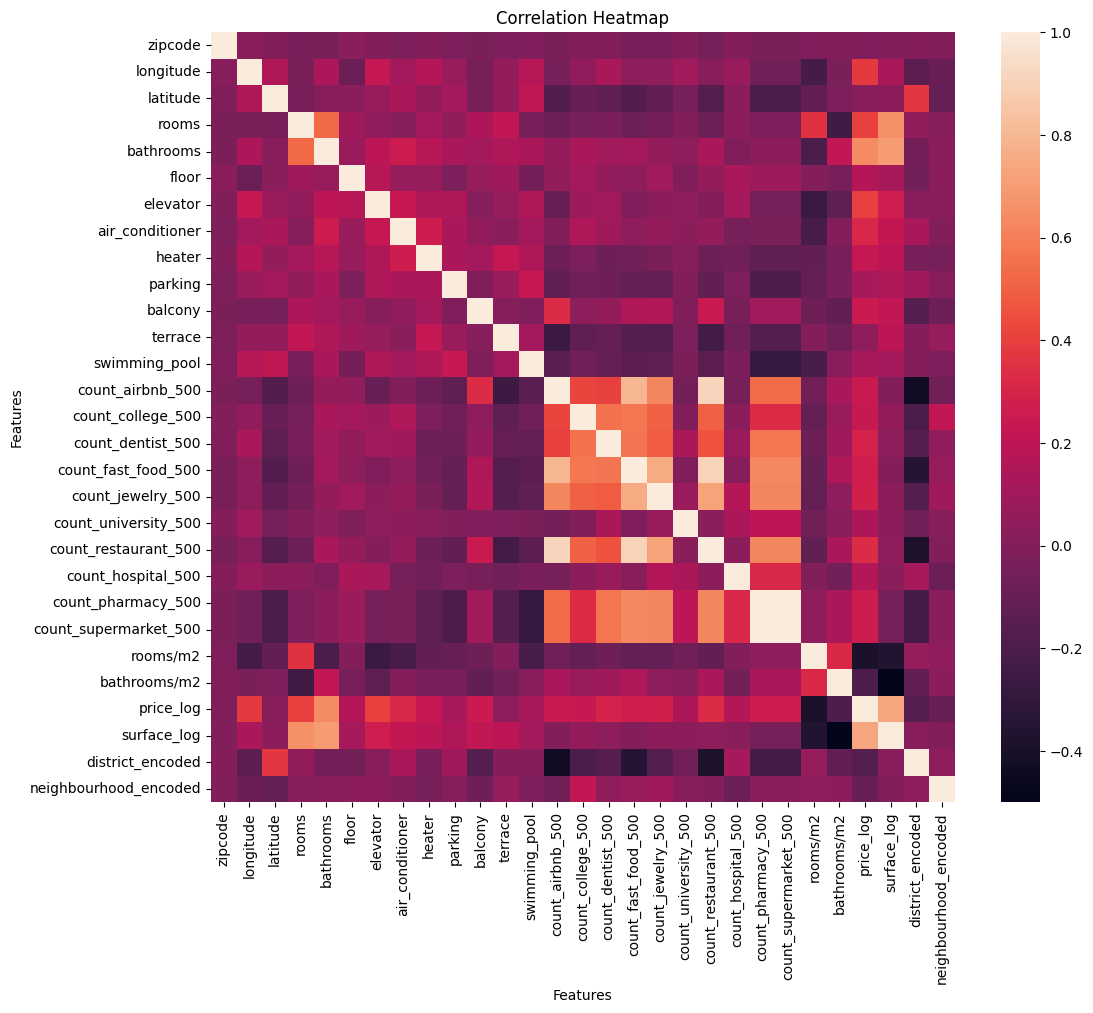

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df_filterd.corr()
# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix)

# Set the title and labels
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

# Display the heatmap
plt.show()

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


X = df_filterd.drop('price_log', axis=1)
y = df_filterd['price_log'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
r_squared_train = model.score(X_train, y_train)

y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r_squared_test = model.score(X_test, y_test)

print("RMSE - Training set:", mse_train)
print("R² - Training set:", r_squared_train)
print("RMSE - Test set:", mse_test)
print("R² - Test set:", r_squared_test)


RMSE - Training set: 0.07999121029319588
R² - Training set: 0.8137616339475947
RMSE - Test set: 0.08106823878074648
R² - Test set: 0.8029515392421877


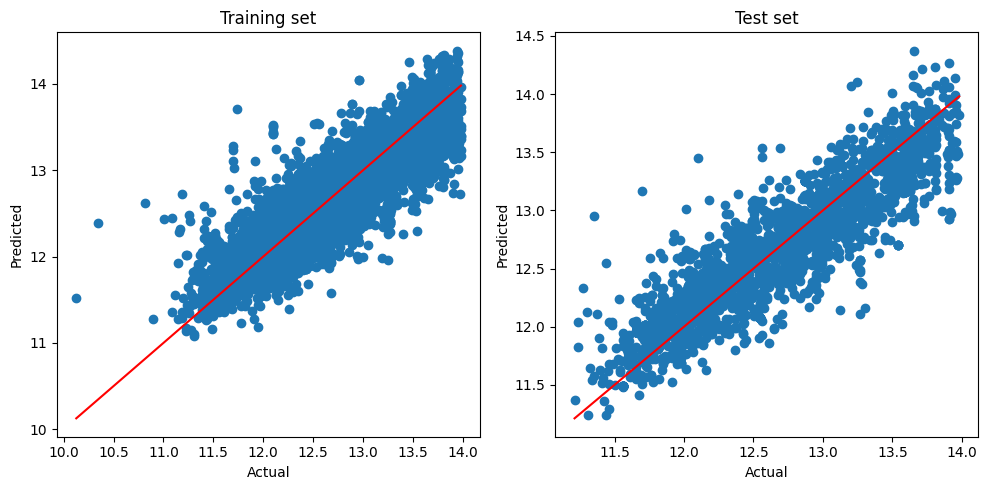

In [94]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red') # line y=x
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training set')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # line y=x
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test set')

plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import mean_squared_error, r2_score

random_forest = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)

random_forest.fit(X_train, y_train)

y_train_pred_rf = random_forest.predict(X_train)

y_test_pred_rf = random_forest.predict(X_test)

rmse_train = mean_squared_error(y_train, y_train_pred_rf)
rmse_test = mean_squared_error(y_test, y_test_pred_rf)

r2_train = r2_score(y_train, y_train_pred_rf)
r2_test = r2_score(y_test, y_test_pred_rf)

print("RMSE - Training set:", rmse_train)
print("RMSE - Test set:", rmse_test)
print("R² - Training set:", r2_train)
print("R² - Test set:", r2_test)

RMSE - Training set: 0.004073195974470986
RMSE - Test set: 0.02824110711515139
R² - Training set: 0.9905166410144786
R² - Test set: 0.9313557717444982


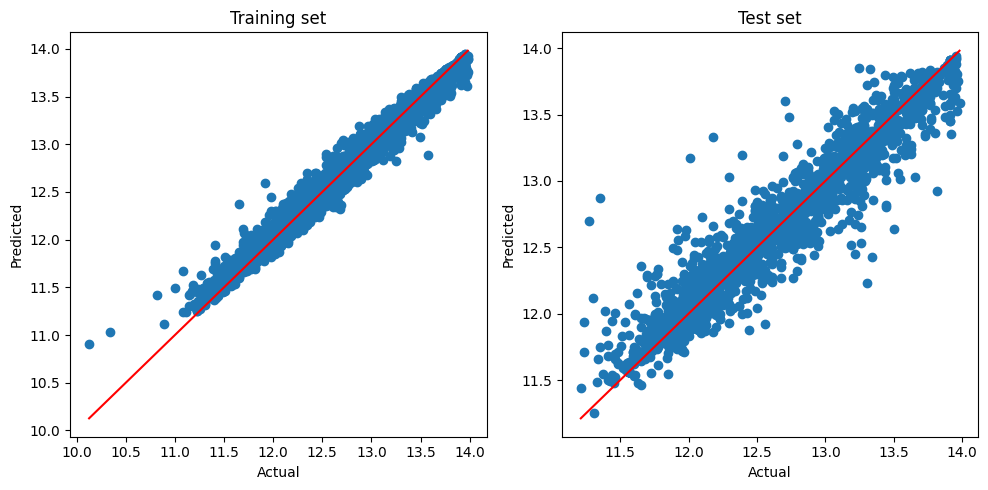

In [96]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red') # line y=x
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training set')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # line y=x
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test set')

plt.tight_layout()
plt.show()

In [97]:
#save the model in a pickle file
import pickle

filename = '../models/rf_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(random_forest, open(filename, 'wb'))

print("Model saved in file: %s" % filename)

Model saved in file: ../models/rf_model.pkl


<Figure size 1000x700 with 0 Axes>

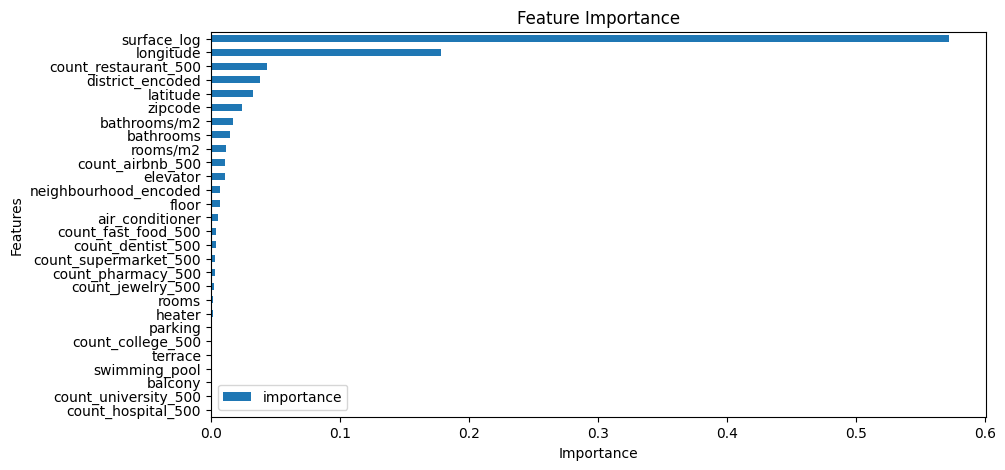

In [98]:
fig = plt.figure(figsize=(10, 7))

feature_importance = random_forest.feature_importances_
features = X_train.columns
df_feature_importance = pd.DataFrame({'features': features, 'importance': feature_importance})

df_feature_importance = df_feature_importance.sort_values('importance', ascending=True)

df_feature_importance.plot(kind='barh', x='features', y='importance', figsize=(10, 5))
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [100]:
print(X_train.columns)

Index(['zipcode', 'longitude', 'latitude', 'rooms', 'bathrooms', 'floor',
       'elevator', 'air_conditioner', 'heater', 'parking', 'balcony',
       'terrace', 'swimming_pool', 'count_airbnb_500', 'count_college_500',
       'count_dentist_500', 'count_fast_food_500', 'count_jewelry_500',
       'count_university_500', 'count_restaurant_500', 'count_hospital_500',
       'count_pharmacy_500', 'count_supermarket_500', 'rooms/m2',
       'bathrooms/m2', 'surface_log', 'district_encoded',
       'neighbourhood_encoded'],
      dtype='object')


In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10420 entries, 2772 to 7967
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zipcode                10420 non-null  int64  
 1   longitude              10420 non-null  float64
 2   latitude               10420 non-null  float64
 3   rooms                  10420 non-null  int64  
 4   bathrooms              10420 non-null  int64  
 5   floor                  10420 non-null  int64  
 6   elevator               10420 non-null  int64  
 7   air_conditioner        10420 non-null  int64  
 8   heater                 10420 non-null  int64  
 9   parking                10420 non-null  int64  
 10  balcony                10420 non-null  int64  
 11  terrace                10420 non-null  int64  
 12  swimming_pool          10420 non-null  int64  
 13  count_airbnb_500       10420 non-null  float64
 14  count_college_500      10420 non-null  float64
 15  count